In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as scs
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib as mpl
from trend_following import jupyter_interactive_mode
%matplotlib inline

In [142]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
jupyter_interactive_mode()

In [3]:
# from backtester.dataSource.yahoo_data_source import YahooStockDataSource
# start_date = '2016/12/31'
# end_date = '2021/09/30'
# cached_folder = '/Users/adheerchauhan/Documents/Tutorials/yahooData/'
# dataSetId = 'TimeSeriesModeling'
# instrumentIds = ['ETH-USD']
# ds = YahooStockDataSource(cachedFolderName=cached_folder,
#                          dataSetId=dataSetId,
#                          instrumentIds=instrumentIds,
#                          startDateStr=start_date,
#                          endDateStr=end_date,
#                          event='history')

In [4]:
# print("List of available Features: %s"%ds.getBookDataFeatures())
# data_dict = ds.getBookDataByFeature()

In [5]:
import yfinance as yf

def load_financial_data(start_date, end_date, ticker='ETH-USD'):
    output_file=f'data_folder/{ticker}-pickle-{start_date}-{end_date}'
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading {ticker} data')
    except FileNotFoundError:
        print(f'File not found...downloading the {ticker} data')
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [6]:
start_date = pd.datetime(2016, 1, 1)
end_date = pd.datetime(2022, 4, 13)
data = load_financial_data(start_date, end_date)
data.columns = ['open', 'high', 'low', 'close', 'adjClose', 'volume']

File data found...reading ETH-USD data


In [7]:
data.head()

,open,high,low,close,adjClose,volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [8]:
# data = pd.concat(data_dict, axis=1)
# data = data.droplevel(1, axis=1)
data = data.assign(pct_returns = data['adjClose'].pct_change())
data = data.assign(log_returns = np.log(data.adjClose/data.adjClose.shift(1))).dropna()

In [9]:
data.tail()

,open,high,low,close,adjClose,volume,pct_returns,log_returns
Date,,,,,,,,
2022-04-09,3191.976074,3261.963135,3187.469238,3261.916260,3261.916260,9908112156,0.021880,0.021644
2022-04-10,3261.291504,3303.003174,3211.866943,3211.866943,3211.866943,10427054790,-0.015344,-0.015462
2022-04-11,3209.576904,3214.461914,2962.756592,2981.052246,2981.052246,21891804831,-0.071863,-0.074576
2022-04-12,2981.420654,3077.452637,2957.872314,3030.376465,3030.376465,20235707410,0.016546,0.016411
2022-04-13,3029.877930,3123.575439,3006.481689,3118.344238,3118.344238,16088473629,0.029029,0.028615


In [10]:
# Augmented Dickey Fuller Test for adjClose Prices
adfuller_test = adfuller(data['adjClose'])
print('ADF Statistic: %f'%adfuller_test[0])
print('p-value: %f'%adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f'%(key,value))

ADF Statistic: -0.563456
p-value: 0.879028
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [11]:
# Augmented Dickey Fuller Test for Log Returns
adfuller_test = adfuller(data['pct_returns'])
print('ADF Statistic: %f'%adfuller_test[0])
print('p-value: %f'%adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f'%(key,value))

ADF Statistic: -11.899586
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [12]:
# Augmented Dickey Fuller Test for Log Returns
adfuller_test = adfuller(data['log_returns'])
print('ADF Statistic: %f'%adfuller_test[0])
print('p-value: %f'%adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f'%(key,value))

ADF Statistic: -11.991459
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


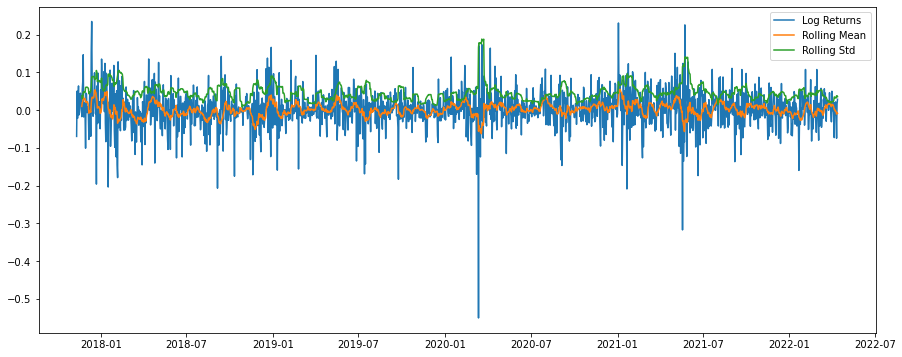

<Figure size 432x288 with 0 Axes>

In [13]:
## Rolling Mean and Standard Deviation
# Assuming 'data' is your time series
rolling_mean = data['log_returns'].rolling(window=12).mean()
rolling_std = data['log_returns'].rolling(window=12).std()

plt.figure(figsize=(15, 6))
plt.plot(data['log_returns'], label='Log Returns')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.show()

plt.tight_layout()

In [14]:
# Function to test for stationarity using the Augmented Dickey-Fuller Test
# This test looks to see if the time series has a unit root
def check_for_stationarity(X, cutoff=0.01):
    # We must observe significant p-values to convince ourselves that a series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name + ' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name + ' is likely non-stationary')
        return False

In [15]:
check_for_stationarity(data['log_returns'])

p-value = 3.513144993937391e-22 The series log_returns is likely stationary.


True

In [16]:
# Function that plots a time series with the autocorrelation(ACF) and partial auto-correlation (PACF) functions
def tsplot(y, lags=None, figsize=(15,10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    return
        

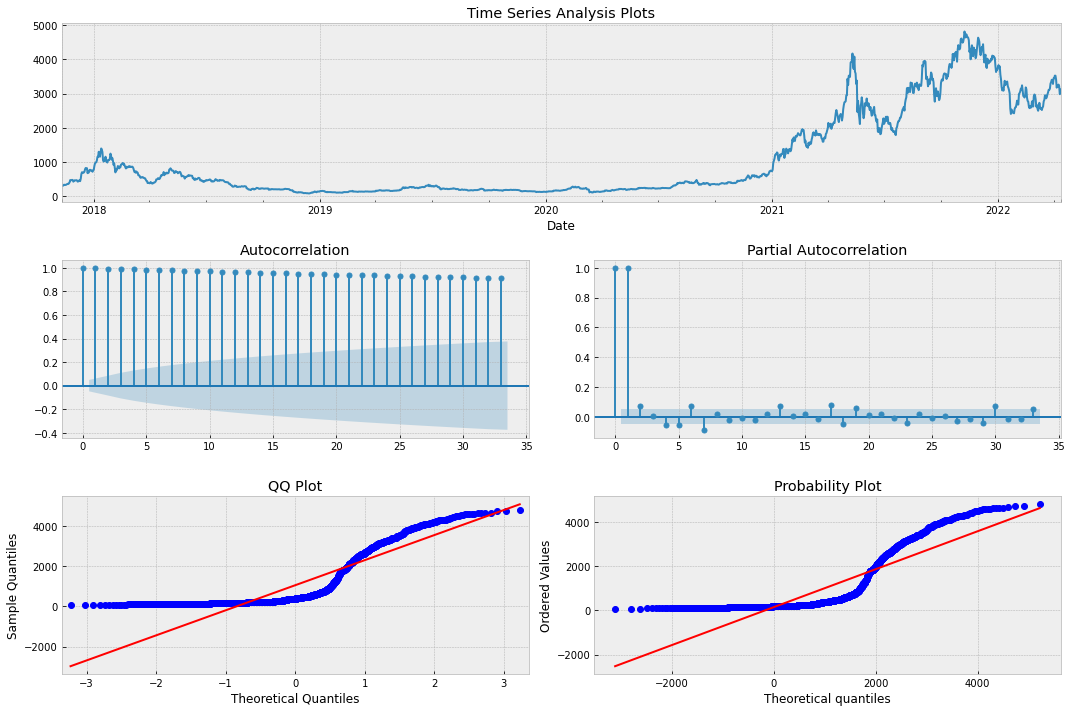

In [17]:
tsplot(data.adjClose)

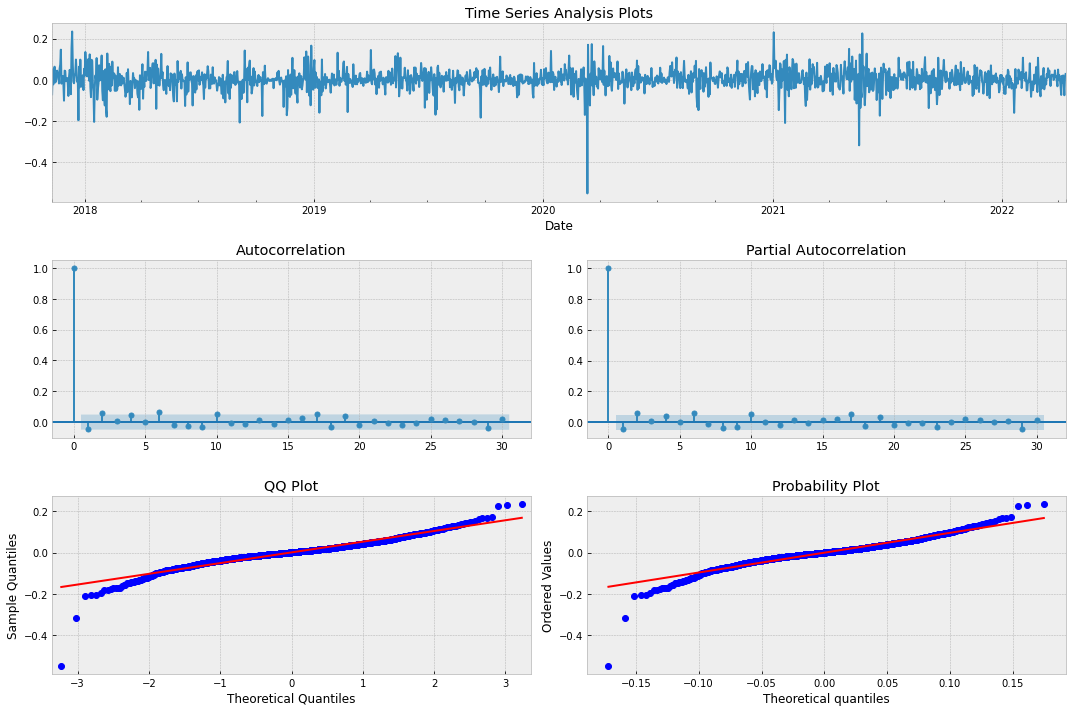

In [18]:
tsplot(data.log_returns, lags=30)

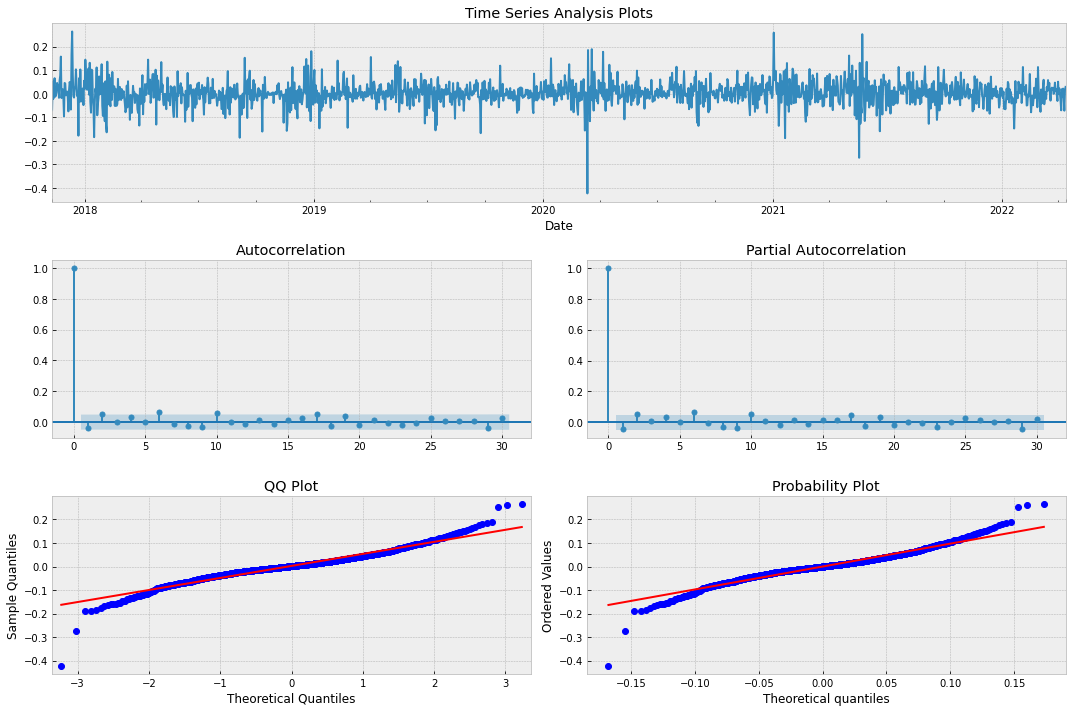

In [19]:
tsplot(data.pct_returns, lags=30)

<Figure size 432x288 with 0 Axes>

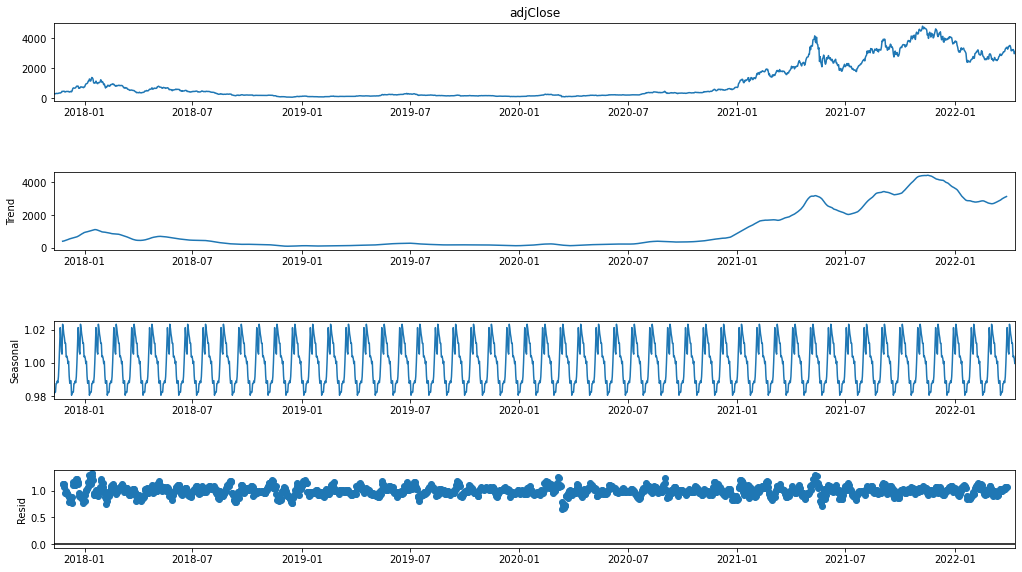

In [20]:
close = seasonal_decompose(data.adjClose, model='multiplicative', freq=30)
fig = plt.figure()
fig = close.plot()
fig.set_size_inches(16,9)

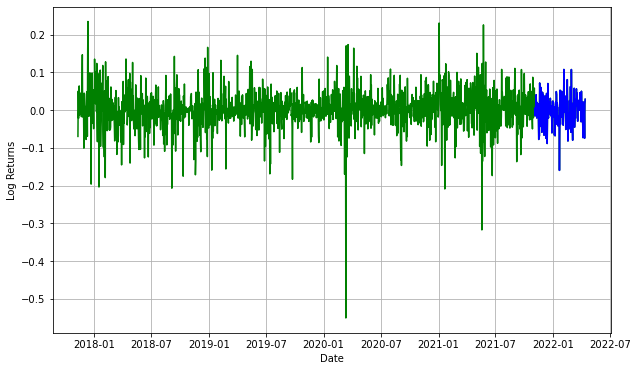

In [21]:
train_data, test_data = (data['log_returns'][3:int(len(data['log_returns'])*0.9)],
                         data['log_returns'][int(len(data['log_returns'])*0.9):])

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.plot(data['log_returns'], color='green', label='Train Data')
plt.plot(test_data, color='blue', label='Test Data')

In [22]:
# Autoregressive Model
# Select the best lag order for the training dataset
max_lag = 30
mdl = smt.AR(train_data).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(train_data).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = %s'%(est_order))

best estimated lag order = 10


In [23]:
## Running a test for normality of the residuals
from statsmodels.stats.stattools import jarque_bera

score, p_value, _, _ = jarque_bera(mdl.resid)

print("P-Value is %.3f"%p_value)
if p_value < 0.10:
    print('We have reason to suspect that the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed')

P-Value is 0.000
We have reason to suspect that the residuals are not normally distributed.


In [24]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      l  -                  o                  g
Model:                         AR(10)   Log Likelihood                2193.237
Method:                          cmle   S.D. of innovations              0.053
Date:                Sun, 11 Aug 2024   AIC                             -5.867
Time:                        11:00:45   BIC                             -5.826
Sample:                    11-13-2017   HQIC                            -5.852
                         - 11-02-2021                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.log_returns     -0.0467      0.026     -1.771      0.077      -0.098       0.005
L2.log_returns      0.0666      0.026      2.521      0.012       0.015       0.118
L3.log_returns      0.0140      0.026      0.530      0.596      -0.038       0.066
L4.log_returns      0.0410      0.026      1.549      0.121      -0.011       0.093
L5.log_returns      0.0115      0.026      0.435      0.664      -0.040       0.063
L6.log_returns      0.0587      0.026      2.220      0.026       0.007       0.111
L7.log_returns     -0.0094      0.026     -0.356      0.722      -0.061       0.042
L8.log_returns     -0.0425      0.026     -1.606      0.108      -0.094       0.009
L9.log_returns     -0.0350      0.026     -1.324      0.185      -0.087       0.017
L10.log_returns     0.0603      0.026      2.282      0.022       0.009       0.112
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2440           -0.0000j            1.2440           -0.5000
AR.2            -1.0771           -0.7726j            1.3255           -0.4010
AR.3            -1.0771           +0.7726j            1.3255            0.4010
AR.4            -0.4172           -1.2058j            1.2759           -0.3030
AR.5            -0.4172           +1.2058j            1.2759            0.3030
AR.6             0.4647           -1.1832j            1.2712           -0.1904
AR.7             0.4647           +1.1832j            1.2712            0.1904
AR.8             1.2466           -0.7217j            1.4405           -0.0835
AR.9             1.2466           +0.7217j            1.4405            0.0835
AR.10            1.3908           -0.0000j            1.3908           -0.0000
------------------------------------------------------------------------------
"""

In [25]:
# Auto Regressive Moving Average Model
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(train_data, order=(i,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except: continue

print('aic: %6.5f | order: %s'%(best_aic, best_order))

aic: -4400.16093 | order: (2, 2)


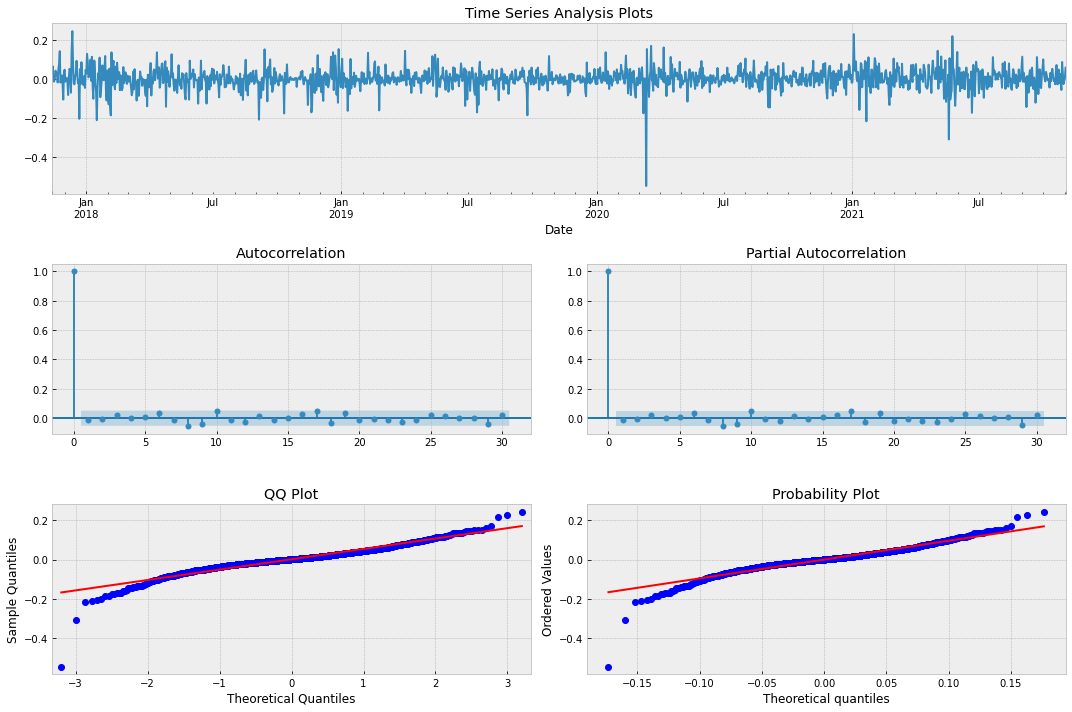

In [26]:
_ = tsplot(best_mdl.resid, lags=max_lag)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
## Fit ARIMA (p,d,q) model to the log returns and close prices
# pick best order and final model based on aic

best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(10)
d_rng = range(2)
for i in pq_rng:
    for j in d_rng:
        for k in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(train_data, order=(i,j,k)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i,j,k)
                    best_mdl = tmp_mdl
            except: continue

print('aic %6.5f | order: %s'%(best_aic, best_order))

# ARIMA model residual plot to test if it is normally distributed with mean 0
_ = tsplot(best_mdl.resid, lags=30)
# warnings.filterwarnings('ignore')

In [92]:
# import numpy as np
# import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA

# # Assuming train_data is your time series data

# # Initialize variables to store the best model information
# best_aic = np.inf
# best_order = None
# best_mdl = None

# # Define the ranges for p, d, q
# pq_rng = range(10)
# d_rng = range(2)

# # Grid search for the best ARIMA model based on AIC
# for i in pq_rng:
#     for j in d_rng:
#         for k in pq_rng:
# #             print(i,j,j)
#             try:
#                 # Fit the ARIMA model
#                 tmp_mdl = ARIMA(train_data, order=(i, j, k)).fit(method='MLE', trend='n')
#                 tmp_aic = tmp_mdl.aic
                
#                 # Update the best model if the current one has a lower AIC
#                 if tmp_aic < best_aic:
#                     best_aic = tmp_aic
#                     best_order = (i, j, k)
#                     best_mdl = tmp_mdl
#             except:
#                 continue

# print('AIC: %6.5f | Best order: %s' % (best_aic, best_order))

# # Plot the residuals to test if they are normally distributed with mean 0
# # Assuming tsplot is a custom function to plot time series diagnostics
# # _ = tsplot(best_mdl.resid, lags=30)

In [95]:
train_data.head()

Date
2017-11-13    0.028204
2017-11-14    0.063948
2017-11-15   -0.012740
2017-11-16   -0.007325
2017-11-17    0.004432
Name: log_returns, dtype: float64

In [97]:
# Step 2: Grid Search for Best ARIMA (p, d, q) Parameters
best_aic = np.inf
best_order = None
best_mdl = None

p_rng = range(11)  # p values from 0 to 20
d_rng = range(3)   # d values from 0 to 2
q_rng = range(11)  # q values from 0 to 20

for p in p_rng:
    for d in d_rng:
        for q in q_rng:
            try:
                # Fit the ARIMA model
                tmp_mdl = ARIMA(train_data.dropna(), order=(p, d, q)).fit()
                tmp_aic = tmp_mdl.aic
                
                # Update the best model if the current one has a lower AIC
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except Exception as e:
                continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

# Step 3: Fit the ARIMA Model with the Best Parameters
best_mdl = ARIMA(train_data.dropna(), order=best_order).fit()

Best ARIMA order: (10, 0, 0) with AIC: -4400.204792280512


In [145]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 1451
Model:                ARIMA(10, 0, 0)   Log Likelihood                2212.102
Date:                Sun, 11 Aug 2024   AIC                          -4400.205
Time:                        18:57:56   BIC                          -4336.845
Sample:                    11-13-2017   HQIC                         -4376.562
                         - 11-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.132      0.258      -0.001       0.005
ar.L1         -0.0474      0.020     -2.335      0.020      -0.087      -0.008
ar.L2          0.0656      0.026      2.523      0.012       0.015       0.117
ar.L3          0.0130      0.025      0.520      0.603      -0.036       0.062
ar.L4          0.0411      0.020      2.014      0.044       0.001       0.081
ar.L5          0.0113      0.023      0.484      0.628      -0.034       0.057
ar.L6          0.0581      0.025      2.343      0.019       0.010       0.107
ar.L7         -0.0104      0.020     -0.523      0.601      -0.049       0.029
ar.L8         -0.0425      0.026     -1.643      0.100      -0.093       0.008
ar.L9         -0.0354      0.026     -1.358      0.174      -0.086       0.016
ar.L10         0.0591      0.025      2.379      0.017       0.010       0.108
sigma2         0.0028   5.19e-05     53.455      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7200.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.03
Prob(H) (two-sided):                  0.10   Kurtosis:                        13.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([10.03966639]), array([0.96744696]))

We perform the Ljung-Box test and find the p-value is significantly larger than 0.05 and as such we can state that there is strong evidence for discrete white noise being a good fit to the residuals. Hence, the ARIMA(2,0,2) model is a good fit, as expected. And our standard test for normality on residuals is below.

In [99]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


In [100]:
jarque_bera(best_mdl.resid)

(7199.351354166515, 0.0, -1.0346707902544718, 13.714353885288864)

In [101]:
# # Forecasting using the best model
# n_steps = 159#len(test_data)

# f, err95, ci95 = best_mdl.forecast(n_steps) # 95% Confidence Interval
# _, err99, ci99 = best_mdl.forecast(n_steps, alpha=0.01) # 99% Confidence Interval
# idx = pd.date_range(train_data.index[-1], periods=n_steps, freq='D')
# fc_95 = pd.DataFrame(np.column_stack([f,ci95]),
#                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
# fc_99 = pd.DataFrame(np.column_stack([ci99]),
#                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
# fc_all = fc_95.combine_first(fc_99)
# fc_all

In [133]:
len(test_data)

162

In [134]:
# Step 2: Forecasting using the best ARIMA model
n_steps = len(test_data)
forecast_obj = best_mdl.get_forecast(steps=n_steps)

# Extracting the forecast, 95% and 99% confidence intervals
forecast = forecast_obj.predicted_mean
ci95 = forecast_obj.conf_int(alpha=0.05)
ci99 = forecast_obj.conf_int(alpha=0.01)

# Step 3: Create an index for the forecasted periods
idx = pd.date_range(train_data.index[-1], periods=n_steps + 1, freq='D')[1:]

# Step 4: Combine forecast with confidence intervals into a DataFrame
fc_95 = pd.DataFrame({
    'forecast': forecast,
    'lower_ci_95': ci95.iloc[:, 0],
    'upper_ci_95': ci95.iloc[:, 1]
})#, index=idx)

fc_99 = pd.DataFrame({
    'lower_ci_99': ci99.iloc[:, 0],
    'upper_ci_99': ci99.iloc[:, 1]
})#, index=idx)

# Step 5: Combine both confidence intervals DataFrames
fc_all = fc_95.combine_first(fc_99)

In [143]:
fc_all#.tail(50)

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2021-11-03,0.002980,-0.100262,-0.132703,0.106223,0.138664
2021-11-04,0.010381,-0.092977,-0.125455,0.113739,0.146216
2021-11-05,-0.002271,-0.105866,-0.138419,0.101324,0.133876
2021-11-06,-0.002574,-0.106172,-0.138725,0.101023,0.133576
2021-11-07,0.008103,-0.095597,-0.128182,0.111803,0.144388
2021-11-08,0.007672,-0.096032,-0.128618,0.111376,0.143962
2021-11-09,0.000130,-0.103777,-0.136428,0.104038,0.136688
2021-11-10,-0.000592,-0.104509,-0.137163,0.103326,0.135980
2021-11-11,0.000171,-0.103797,-0.136466,0.104139,0.136808
2021-11-12,0.004804,-0.099215,-0.131900,0.108822,0.141507


In [141]:
pd.DataFrame({
    'forecast': forecast,
    'lower_ci_95': ci95.iloc[:, 0],
    'upper_ci_95': ci95.iloc[:, 1]
})

,forecast,lower_ci_95,upper_ci_95
2021-11-03,0.002980,-0.100262,0.106223
2021-11-04,0.010381,-0.092977,0.113739
2021-11-05,-0.002271,-0.105866,0.101324
2021-11-06,-0.002574,-0.106172,0.101023
2021-11-07,0.008103,-0.095597,0.111803
...,...,...,...
2022-04-09,0.001874,-0.102362,0.106109
2022-04-10,0.001874,-0.102362,0.106109
2022-04-11,0.001874,-0.102362,0.106109
2022-04-12,0.001874,-0.102362,0.106109


In [88]:
fc_all

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2022-04-14,-0.000665,-0.101946,-0.133771,0.100616,0.132441
2022-04-15,0.001790,-0.099579,-0.131431,0.103159,0.135011
2022-04-16,0.001121,-0.100429,-0.132338,0.102670,0.134579
2022-04-17,-0.002082,-0.103639,-0.135550,0.099475,0.131387
2022-04-18,0.002714,-0.098916,-0.130851,0.104344,0.136279
...,...,...,...,...,...
2022-09-15,0.001401,-0.100435,-0.132434,0.103237,0.135236
2022-09-16,0.001401,-0.100435,-0.132434,0.103237,0.135236
2022-09-17,0.001401,-0.100435,-0.132434,0.103237,0.135236
2022-09-18,0.001401,-0.100435,-0.132434,0.103237,0.135236


In [90]:
test_data.head()

Date
2021-11-03    0.004873
2021-11-04   -0.015282
2021-11-05   -0.011322
2021-11-06    0.007846
2021-11-07    0.021653
Name: log_returns, dtype: float64

In [ ]:
fc_all.shape

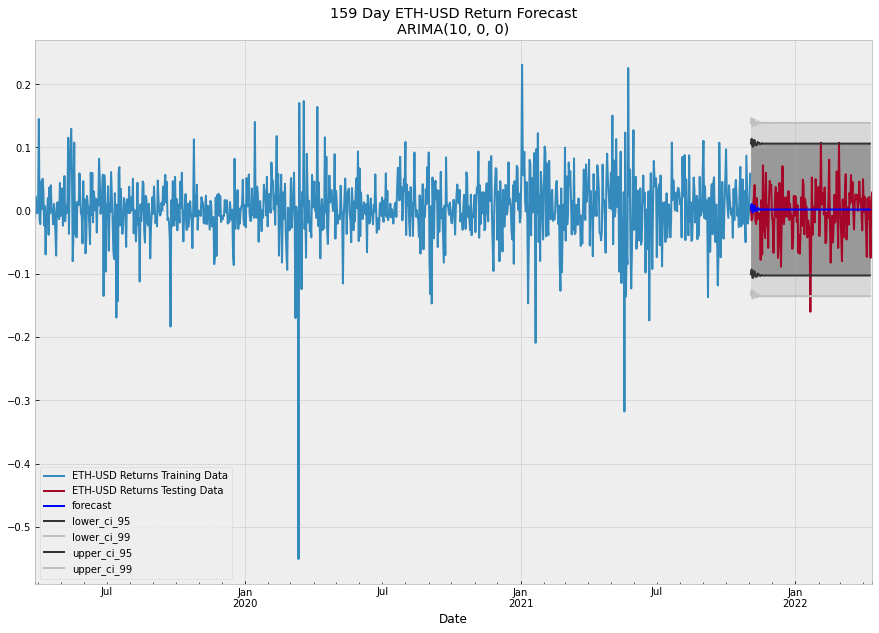

In [104]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

# ts = data['log_returns'].iloc[500:].copy()
ts = train_data.iloc[500:].copy()
_ = ts.plot(ax=ax, label='ETH-USD Returns Training Data')
ts_2 = test_data.copy()
_ = ts_2.plot(ax=ax, label='ETH-USD Returns Testing Data')

styles = ['b-','0.2','0.75','0.2','0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day ETH-USD Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

In [105]:
df_error = pd.merge(pd.DataFrame(test_data), fc_all, left_index=True, right_index=True, how='left')
df_error.shape
df_error.dropna(inplace=True)

In [106]:
df_error[df_error['forecast'].isnull()].shape

(0, 6)

In [107]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
mse = mean_squared_error(df_error.log_returns, df_error.forecast)
rmse = math.sqrt(mse)
mae = mean_absolute_error(df_error.log_returns, df_error.forecast)
r2 = r2_score(df_error.log_returns, df_error.forecast)

In [108]:
print('Mean Squared Error: %.3f' %mse)
print('Mean Absolute Error: %.3f' %mae)
print('Root Mean Squared Error: %.3f' %rmse)
print('R2 Variance Error: %.3f' %r2)

Mean Squared Error: 0.002
Mean Absolute Error: 0.030
Root Mean Squared Error: 0.039
R2 Variance Error: -0.010


## Trend Following using ARIMA Model

In [117]:
def generate_signal(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy signal
    elif predicted_return < -threshold:
        return -1  # Sell signal
    else:
        return 0  # Hold signal

In [ ]:
# Step 3: Predict and Generate Signals on the Entire Dataset (including both train and test data)
for i in range(len(log_returns_df) - 1):
    if i < train_size - 1:
        # For the training data, use the existing model
        forecast_obj = model.get_forecast(steps=1)
    else:
        # For the testing data, fit the model on the expanding window (including all data up to that point)
        model = ARIMA(log_returns_df.iloc[:i+1], order=(p, d, q)).fit()
        forecast_obj = model.get_forecast(steps=1)
    
    # Predict the next day's return
    predicted_return = forecast_obj.predicted_mean[0]
    predicted_returns.append(predicted_return)
    
    # Generate trading signals based on the predicted return
    if predicted_return > threshold:
        signals.append(1)  # Long signal
    elif predicted_return < -threshold:
        signals.append(-1)  # Short signal
    else:
        signals.append(0)  # Hold signal

In [127]:
test_data

Date
2021-11-03    0.004873
2021-11-04   -0.015282
2021-11-05   -0.011322
2021-11-06    0.007846
2021-11-07    0.021653
                ...   
2022-04-09    0.021644
2022-04-10   -0.015462
2022-04-11   -0.074576
2022-04-12    0.016411
2022-04-13    0.028615
Name: log_returns, Length: 162, dtype: float64

In [118]:
# Fit the ARIMA model with the best parameters
best_mdl = ARIMA(train_data.dropna(), order=best_order).fit()

# Forecast future returns (e.g., one-step-ahead prediction)
n_steps = 1  # Predict one period ahead (can adjust for multi-step forecasting)
forecast_obj = best_mdl.get_forecast(steps=n_steps)
predicted_return = forecast_obj.predicted_mean[-1]  # Get the predicted return

In [120]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 1451
Model:                ARIMA(10, 0, 0)   Log Likelihood                2212.102
Date:                Sun, 11 Aug 2024   AIC                          -4400.205
Time:                        17:46:48   BIC                          -4336.845
Sample:                    11-13-2017   HQIC                         -4376.562
                         - 11-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.132      0.258      -0.001       0.005
ar.L1         -0.0474      0.020     -2.335      0.020      -0.087      -0.008
ar.L2          0.0656      0.026      2.523      0.012       0.015       0.117
ar.L3          0.0130      0.025      0.520      0.603      -0.036       0.062
ar.L4          0.0411      0.020      2.014      0.044       0.001       0.081
ar.L5          0.0113      0.023      0.484      0.628      -0.034       0.057
ar.L6          0.0581      0.025      2.343      0.019       0.010       0.107
ar.L7         -0.0104      0.020     -0.523      0.601      -0.049       0.029
ar.L8         -0.0425      0.026     -1.643      0.100      -0.093       0.008
ar.L9         -0.0354      0.026     -1.358      0.174      -0.086       0.016
ar.L10         0.0591      0.025      2.379      0.017       0.010       0.108
sigma2         0.0028   5.19e-05     53.455      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7200.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.03
Prob(H) (two-sided):                  0.10   Kurtosis:                        13.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
best_mdl.forecast(n_steps=1)

2021-11-03    0.00298
Freq: D, dtype: float64

In [130]:
# Predict returns for the next period (you can adjust the steps if needed)
n_steps = 1  # Predict one period ahead (e.g., next day's return)

# Forecasting over the full dataset
predicted_returns = best_mdl.get_forecast(steps=n_steps).predicted_mean

# Generate trading signals
def generate_signal(predicted_return, threshold=0):
    if predicted_return > threshold:
        return 1  # Buy signal
    elif predicted_return < -threshold:
        return -1  # Sell signal
    else:
        return 0  # Hold signal

signals = predicted_returns.apply(generate_signal)

In [131]:
signals

2021-11-03    1
Freq: D, dtype: int64

In [132]:
signals.shift(1).fillna(0)

2021-11-03    0.0
Freq: D, dtype: float64

In [ ]:
best_mdl.forecast()

In [129]:
data.head()

,open,high,low,close,adjClose,volume,pct_returns,log_returns
Date,,,,,,,,
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984,-0.067411,-0.069790
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,0.051555,0.050270
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,-0.021523,-0.021758
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,0.028606,0.028204
2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1069680000,0.066037,0.063948


In [125]:
# Access AR (Auto-Regressive) coefficients
ar_params = best_mdl.arparams
print("AR Coefficients:", ar_params)

# Access MA (Moving Average) coefficients
# ma_params = best_mdl.maparams
# print("MA Coefficients:", ma_params)

# Access the constant term (if applicable)
const = best_mdl.params.get('const', None)
if const is not None:
    print("Constant Term:", const)

# Access the differencing term (d)
differencing_order = best_order[1]
print("Differencing Term (d):", differencing_order)

AR Coefficients: [-0.04738157  0.06563972  0.01302377  0.04111893  0.01125129  0.05814138
 -0.01039567 -0.04249348 -0.03539342  0.05908879]
Constant Term: 0.0018737632100480606
Differencing Term (d): 0


In [119]:
# Assuming 'signals' is a list to store the generated signals
signals = []

for i in range(len(train_data)):
    if i < len(train_data) - n_steps:
        # Fit the model on the current data up to the current point
        model = ARIMA(train_data[:i+1], order=best_order).fit()
        
        # Forecast the next return
        forecast_obj = model.get_forecast(steps=n_steps)
        predicted_return = forecast_obj.predicted_mean[-1]
        
        # Generate the trading signal
        signal = generate_signal(predicted_return)
        signals.append(signal)

# Convert signals to a DataFrame for further analysis
signals_df = pd.DataFrame(signals, index=train_data.index[:-n_steps], columns=['Signal'])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
data['log_returns_pred'] = best_mdl.f

In [109]:
data.head()

,open,high,low,close,adjClose,volume,pct_returns,log_returns
Date,,,,,,,,
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984,-0.067411,-0.069790
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,0.051555,0.050270
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,-0.021523,-0.021758
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,0.028606,0.028204
2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1069680000,0.066037,0.063948


# Implementing a Linear Regression Model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

def linear_regression(x_train, y_train, x_test, y_test):
    regr = linear_model.LinearRegression()
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the testing set
    y_pred = regr.predict(x_test)
    
    # Print the coefficients of the model
    print('Coefficients: \n', regr.coef_)
    
    # Print the Mean Squared Error
    print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
    
    # Print the Variance Score
    print('R2 Variance Score: %.4f' %r2_score(y_test, y_pred))
    
    # Plot the outputs
    plt.scatter(y_pred, y_test)
    plt.plot(y_test, y_test, linewidth=3)
    plt.xlabel('Y(actual)')
    plt.ylabel('Y(predicted)')
    plt.show()
    
    return regr, y_pred

In [ ]:
train_data.head()

In [ ]:
# train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
# test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)
pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

In [ ]:
train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)
regr_model, y_pred = linear_regression(x_train=np.array(train_data.index).reshape(-1,1), y_train=train_data,
                                       x_test=np.array(test_data.index).reshape(-1,1), y_test=test_data)

In [ ]:
## Plot ETH forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

# ts = data['log_returns'].iloc[500:].copy()
ts = train_data.iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data.copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [ ]:
# Linear Regression Model using Volume and the Close Price as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['adjClose','volume']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

In [ ]:
## Plot ETH forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [ ]:
# Building features for momentum
def difference(df, period):
    return df.sub(df.shift(period), fill_value=0)

In [ ]:
data = data.assign(mom10 = difference(data.log_returns, 11))
data = data.assign(mom50 = difference(data.log_returns, 51))
data = data.assign(mom100 = difference(data.log_returns, 101))
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

In [ ]:
# Linear Regression Model using Open Price, Volume, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

In [ ]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [ ]:
# Linear Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

In [ ]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [ ]:
# Linear Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                       x_test=test_data[features], y_test=test_data[target])

In [ ]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [ ]:
ypred.tail()

In [ ]:
ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.head()

In [ ]:
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [ ]:
data.shift(1).head()

In [ ]:
data.close.pct_change()head()

In [ ]:
# data = data.assign(log_returns = np.log(data.close/data.close.shift(1))).dropna()
ypred = ypred.assign(pred_returns = np.exp(ypred.pred_log_returns))
ypred = ypred.assign(pred_prices = np.cumprod(ypred.pred_returns) + ypred.adjClose.iloc[0])

In [ ]:
train_data.tail()

In [ ]:
ypred.head()

In [ ]:
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
# _ = ax.plot(ypred['pred_returns'], label='ETH-USD Predicted Absolute Returns',color='green')
_ = ax.plot(ypred['pred_prices'], label='ETH-USD Predicted Prices',color='blue')
_ = ax.plot(ypred['adjClose'], label='ETH-USD Actual Prices',color='green')
_ = ax.legend()

In [ ]:
import seaborn

c = data.corr()
plt.figure(figsize=(10,10))
_ = seaborn.heatmap(c, cmap='RdYlGn_r', mask=(np.abs(c) <= 0.8))

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

def lasso_regression(x_train, y_train, x_test, y_test, alpha=0.3):
    regr = linear_model.Lasso(alpha)
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the testing set
    y_pred = regr.predict(x_test)
    
    # Print the coefficients of the model
    print('Coefficients: \n', regr.coef_)
    
    # Print the Mean Squared Error
    print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
    
    # Print the Variance Score
    print('R2 Variance Score: %.4f' %r2_score(y_test, y_pred))
    
    # Plot the outputs
    plt.scatter(y_pred, y_test)
    plt.plot(y_test, y_test, linewidth=3)
    plt.xlabel('Y(actual)')
    plt.ylabel('Y(predicted)')
    plt.show()
    
    return regr, y_pred

In [ ]:
# Lasso Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = lasso_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

In [ ]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

def ridge_regression(x_train, y_train, x_test, y_test, alpha=10000):
    regr = linear_model.Ridge(alpha)
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the testing set
    y_pred = regr.predict(x_test)
    
    # Print the coefficients of the model
    print('Coefficients: \n', regr.coef_)
    
    # Print the Mean Squared Error
    print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
    
    # Print the Variance Score
    print('R2 Variance Score: %.4f' %r2_score(y_test, y_pred))
    
    # Plot the outputs
    plt.scatter(y_pred, y_test)
    plt.plot(y_test, y_test, linewidth=3)
    plt.xlabel('Y(actual)')
    plt.ylabel('Y(predicted)')
    plt.show()
    
    return regr, y_pred

In [ ]:
# Ridge Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = ridge_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

In [ ]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()